NOTE: EACH TOOL THAT WE ARE BINDING HAS TO BE DEFINED IN A FUNCTION. THESE FUNCTIONS HAVE TO HAVE GOOD DOCSTRINGS, THAT DESCRIBE CLEARLY WHEN THEY ARE USED AND WHAT THEY DO. WITHOUT THIS, THE LLM WILL GET CONFUSED AS TO WHICH TOOL TO USE.

## Chatbot that uses Websearch
a chatbot made with langgraph that uses web search (tavily search api)

In [5]:
from typing import Annotated 
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages 

In [6]:
class AgentState(TypedDict):
    """Messages are of type list, and the annotation defines how the list is updated
    In this case, the add_messages reducer is telling it to append new messages to the list instead of replacing it.
    """
    messages: Annotated[list, add_messages]
    
graph = StateGraph(AgentState)
graph

In [7]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()  

llm = ChatGroq(
    model_name=os.getenv("MODEL_NAME"),
    api_key=os.getenv("GROQ_API_KEY") 
)

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x140644cd0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x140645590>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is the recent finance news from within a month ago?")

{'query': 'What is the recent finance news from within a month ago?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.reuters.com/business/finance/',
   'title': "Latest Finance News | Today's Top Headlines - Reuters",
   'content': "Finance ; Chime beats revenue estimates in first earnings since blowout US IPO. 12 hours ago ; Trump targets banks with order barring discriminatory 'debanking'.",
   'score': 0.50564,
   'raw_content': None},
  {'url': 'https://www.cnbc.com/finance/',
   'title': 'Finance News - CNBC',
   'content': "1. Couple in their 50s makes $188,000 a year, but doesn't 'spend any money': 'We're living too little of a life,' wife says · 2. Are $600 tariff rebate checks",
   'score': 0.42648935,
   'raw_content': None}],
 'response_time': 1.43}

Making a custom function to bind two tools

In [9]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

tools=[tool,multiply]
llm_with_tool=llm.bind_tools(tools)
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x140644cd0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x140645590>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to re

Binding an LLM with tools enables it to understand properly which tools are at its disposal. (without the use of MCP Servers being necessary for simple usecases)

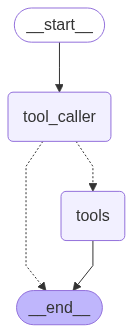

In [10]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
# build graph
graph = StateGraph(AgentState)

# define tolnodes
def tool_caller(state:AgentState) -> AgentState:
    """This node calls tools and appends the results to the messages list."""
    return {
        "messages":state["messages"] + [llm_with_tool.invoke(state["messages"])]
        }

# add nodes
graph.add_node("tool_caller", tool_caller)
graph.add_node("tools", ToolNode(tools))



# add edges conditionally
graph.add_edge(START, "tool_caller")
graph.add_conditional_edges(
    "tool_caller", 
    # if the last message in messages is a tool call, go to tools node
    tools_condition,
    # if the last message is not a tool call, go to END node
    END
)
graph.add_edge("tools", END)

# compile graph
app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
response=app.invoke({"messages":"What is the recent ai news"})
response["messages"][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4035385/beef-up-ai-security-with-zero-trust-principles.html", "title": "Beef up AI security with zero trust principles - csoonline.com", "score": 0.7077487, "published_date": "Thu, 07 Aug 2025 04:34:24 GMT", "content": "News ### ReVault flaws let attackers bypass Windows login or place malware implants on Dell laptops By John Leyden Aug 6, 2025 4 mins Black Hat Security Hardware VulnerabilitiesFeature ### How cybersecurity leaders are securing AI infrastructures By Maria Korolov Aug 6, 2025 10 mins Artificial Intelligence Generative AI Security InfrastructureNews ### Nvidia patches critical Triton server bugs that threaten AI model security By Shweta Sharma Aug 5, 2025 4 mins Artificial Intelligence Security Vulnerabilities news ### Beef up AI security with zero trust principles By Howard Solomon Aug 7, 2025 6 mins Artificial Intelligence Black 

In [12]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (88tz8jk2h)
 Call ID: 88tz8jk2h
  Args:
    query: recent ai news
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4035385/beef-up-ai-security-with-zero-trust-principles.html", "title": "Beef up AI security with zero trust principles - csoonline.com", "score": 0.7077487, "published_date": "Thu, 07 Aug 2025 04:34:24 GMT", "content": "News ### ReVault flaws let attackers bypass Windows login or place malware implants on Dell laptops By John Leyden Aug 6, 2025 4 mins Black Hat Security Hardware VulnerabilitiesFeature ### How cybersecurity leaders are securing AI infra

In [13]:
response=app.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (n5jgfhyrn)
 Call ID: n5jgfhyrn
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [14]:
response=app.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (ktby9zpes)
 Call ID: ktby9zpes
  Args:
    query: latest AI news
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://news.mit.edu/topic/artificial-intelligence2", "title": "Artificial intelligence | Massachusetts Institute of Technology", "content": "The simulations matched results from an underground lab experiment in Switzerland, suggesting modeling could be used to validate the safety of nuclear disposal sites.\n\nJuly 18, 2025\n\nRead full story →\n\nA robot thinking between numbers and letters\n\n### This “smart coach” helps LLMs s

Note: in this case, due to the structure of our graph, even though it noticed that both tools were rqeuired and called both of them, after generating the output from the first (news) tool, it skipped to the END node and then the graph ended. Hence, it never gave us the result of multiplication.

## How to fix this problem?

Instead of skipping to the end node after running the tool node, we can give the output after calling the tool back to the LLM. Then the LLM can decide weather the response is satisfactory relative to the initial query or not, before skipping to the END node.\
Hence, it will look somewhat like this:
```mermaid
    flowchart TD
    A[Query] --> B[LLM]
    B[LLM] --> C[Tool Node]
    C[Tool Node] --> B[LLM]
    B[LLM] --> END
```

This is where ReAct Agents come into play.